In [1]:
import os

os.chdir("../..")  # need to set path to repo root

In [2]:
from src.dataset import get_segmentation_df

segmentation_df = get_segmentation_df()
segmentation_df.head()
# can be multiple annotations per image, each one represents an individual card and its bounding box

,image_path,x,y,width,height,rotation
0,db/shared/jpg/segmentation/front_scans/0_41855...,14.652956,29.695024,73.264781,64.365971,0.000000
1,db/shared/jpg/segmentation/front_scans/0_41855...,12.728191,29.402256,74.005400,62.439819,1.167279
2,db/shared/jpg/segmentation/front_scans/0_41855...,12.698413,29.534510,74.603175,62.760835,0.000000
3,db/shared/jpg/segmentation/front_scans/0_41855...,15.022358,30.461750,73.262068,62.118780,0.937271
4,db/shared/jpg/segmentation/front_scans/0_41855...,14.138817,29.855538,74.035990,64.365971,0.000000


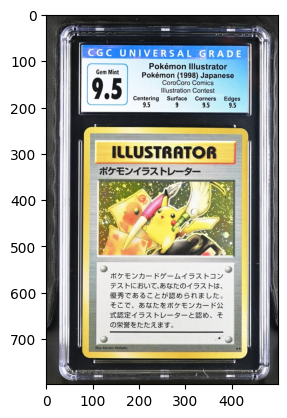

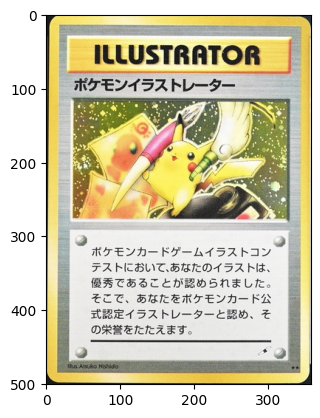

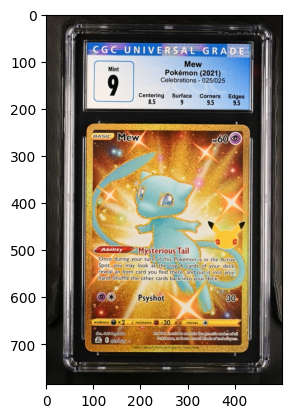

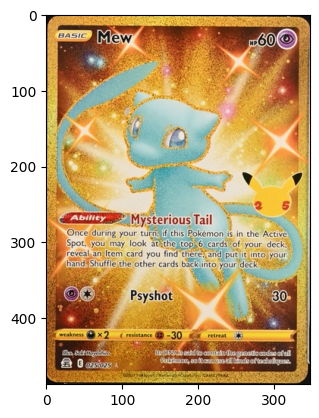

In [3]:
from src.shared.image import display_image, crop_image
from src.shared.storage import Database, ImageStorage
from PIL import Image

# disk storage wrapper for shared nested repository, acts as a "bucket"
front_scans_storage = ImageStorage("segmentation/front_scans", db=Database.SHARED)

# grab 0th annotation and display it
for i in range(101, 103):
    annotation_0 = segmentation_df.iloc[i]
    img = Image.open(annotation_0["image_path"])
    
    top = annotation_0["y"] / 100
    right = (100 - (annotation_0["x"] + annotation_0["width"])) / 100
    bottom = (100 - (annotation_0["y"] + annotation_0["height"])) / 100
    left = annotation_0["x"] / 100
    rotation = annotation_0["rotation"]

    display_image(img)

    cropped_img = crop_image(
        img,
        top,
        right,
        bottom,
        left,
        rotation,
    )
    display_image(cropped_img)


In [4]:
# YOLOv7 / Detectron2

!pip install torch torchvision pyyaml numpy pandas tqdm tensorflow

In [5]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

2023-04-26 15:57:43.976039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
training_images_path = segmentation_df['image_path']
training_images_path

0      db/shared/jpg/segmentation/front_scans/0_41855...
1      db/shared/jpg/segmentation/front_scans/0_41855...
2      db/shared/jpg/segmentation/front_scans/0_41855...
3      db/shared/jpg/segmentation/front_scans/0_41855...
4      db/shared/jpg/segmentation/front_scans/0_41855...
                             ...                        
181    db/shared/jpg/segmentation/front_scans/4126368...
182    db/shared/jpg/segmentation/front_scans/4126381...
183    db/shared/jpg/segmentation/front_scans/4126384...
184    db/shared/jpg/segmentation/front_scans/4126385...
185    db/shared/jpg/segmentation/front_scans/cgc_fro...
Name: image_path, Length: 186, dtype: object

In [7]:
import numpy as np
from PIL import Image

# create a list to store the loaded and normalized images
training_images_norm = []

# loop through each image path and load the image
for path in training_images_path:
    img = Image.open(path)
    resized_image = img.resize((350,220))
    # normalize the pixel values
    img_norm = np.asarray(resized_image) / 255.0
    training_images_norm.append(img_norm)
    
    
print(len(training_images_norm))
print(training_images_norm[0].shape)

186
(220, 350, 3)


In [8]:
training_labels = segmentation_df.iloc[:, 1:]
print(training_labels.head(), len(training_labels))


new_training_labels = training_labels # Reorganising the rotation to be from -180 to 180 
new_training_labels.loc[new_training_labels['rotation'] > 180, 'rotation'] -= 360
new_training_labels['rotation'].min(), new_training_labels['rotation'].max()

           x          y      width     height  rotation
0  14.652956  29.695024  73.264781  64.365971  0.000000
1  12.728191  29.402256  74.005400  62.439819  1.167279
2  12.698413  29.534510  74.603175  62.760835  0.000000
3  15.022358  30.461750  73.262068  62.118780  0.937271
4  14.138817  29.855538  74.035990  64.365971  0.000000 186


(-0.7001172442897428, 1.415526745438001)

In [9]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# create a scaler object
scaler = MinMaxScaler()

# fit the scaler on the original dataframe
scaler.fit(new_training_labels)

# normalize the dataframe
normalized_df = pd.DataFrame(scaler.transform(new_training_labels), columns=new_training_labels.columns)

print(normalized_df)


import tensorflow as tf

# define the input shape
input_shape = (220, 350, 3)

# create the model
model = tf.keras.models.Sequential([
    # convolutional layers
    tf.keras.layers.Conv2D(64, (10, 10), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # flatten the output from the convolutional layers
    tf.keras.layers.Flatten(),
    # dense layers
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # output layer with 5 nodes for the x, y, height, width, and rotation values
    tf.keras.layers.Dense(5)
])

# compile the model with the mean squared error loss function and Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mse')

# train the model on the normalized images and the label values
model.fit(np.array(training_images_norm), np.array(normalized_df), epochs=100)


            x         y     width        height  rotation
0    0.420808  0.310147  0.557841  8.000000e-01  0.330924
1    0.231505  0.220272  0.620457  4.571450e-01  0.882661
2    0.228576  0.260872  0.670996  5.142857e-01  0.330924
3    0.457139  0.545520  0.557611  4.000000e-01  0.773943
4    0.370242  0.359422  0.623043  8.000000e-01  0.330924
..        ...       ...       ...           ...       ...
181  0.479863  0.148741  0.203015  1.154632e-13  0.792832
182  0.373273  0.471741  0.553171  2.857143e-01  0.671564
183  0.208803  0.000000  0.457776  7.147530e-01  0.770349
184  0.721932  0.226913  0.000000  5.714286e-01  0.660506
185  0.275409  0.281897  0.626263  4.571429e-01  0.442143

[186 rows x 5 columns]
Epoch 1/100
6/6 [==============================] - 26s 4s/step - loss: 0.2611
Epoch 2/100
6/6 [==============================] - 23s 4s/step - loss: 0.1025
Epoch 3/100
6/6 [==============================] - 23s 4s/step - loss: 0.0548
Epoch 4/100
6/6 [=============================

6/6 [==============================] - 19s 3s/step - loss: 9.7075e-04
Epoch 96/100
6/6 [==============================] - 19s 3s/step - loss: 0.0010
Epoch 97/100
6/6 [==============================] - 19s 3s/step - loss: 9.3298e-04
Epoch 98/100
6/6 [==============================] - 19s 3s/step - loss: 9.1672e-04
Epoch 99/100
6/6 [==============================] - 19s 3s/step - loss: 8.8945e-04
Epoch 100/100
6/6 [==============================] - 19s 3s/step - loss: 8.4480e-04


1/1 [==============================] - 1s 710ms/step
[[0.3257958  0.1413044  0.19856773 0.26088738 0.27238348]]
Predicted Values ::: [13.686907   29.145021   69.01532    61.337246   -0.12385077]
Actual Values ::: image_path    db/shared/jpg/segmentation/front_scans/4125705...
x                                                     16.520394
y                                                     29.509516
width                                                 70.279113
height                                                 62.11878
rotation                                               0.470591
Name: 123, dtype: object


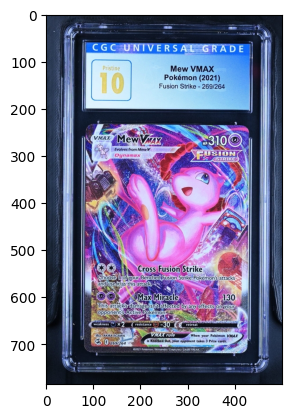

Based on what we predicted ::: 


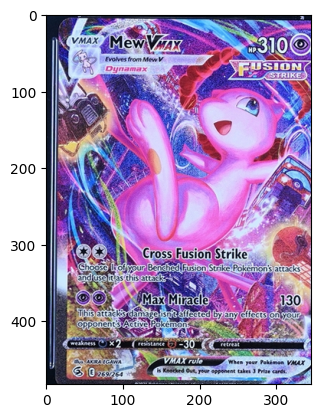

GROUND TRUTH ::: 


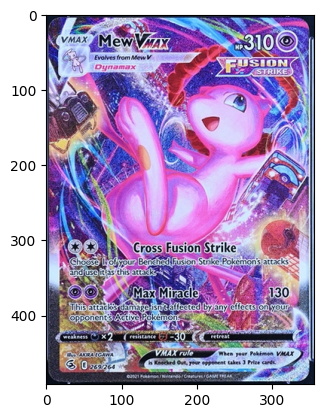

In [10]:
# inverse transform to get the original values

pokemon_number = 123
pokemon_selected = segmentation_df.iloc[pokemon_number]
image_p = pokemon_selected['image_path']
new_image = Image.open(image_p)
resized_image = new_image.resize((350, 220))

# normalize the pixel values
new_image_norm = np.asarray(resized_image) / 255.0
# make a prediction using the trained model
prediction = model.predict(np.array([new_image_norm]))

# the output will be an array of 5 values for the x, y, height, width, and rotation values
print(prediction)

original_values = scaler.inverse_transform(prediction)

prediction = original_values[0]

print('Predicted Values :::', prediction)
print('Actual Values :::', pokemon_selected)

top = prediction[1] / 100
right = (100 - (prediction[0] + prediction[2])) / 100
bottom = (100 - (prediction[1] + prediction[3])) / 100
left = prediction[0] / 100
rotation = prediction[4] 

annotation_0 = image_p 
img = Image.open(annotation_0)

display_image(img)

cropped_img = crop_image(
    img,
    top,
    right,
    bottom,
    left,
    rotation,
)

print("Based on what we predicted ::: ")
display_image(cropped_img)



print("GROUND TRUTH ::: ")



annotation_0 = segmentation_df.iloc[pokemon_number]
img = Image.open(annotation_0["image_path"])

top = annotation_0["y"] / 100
right = (100 - (annotation_0["x"] + annotation_0["width"])) / 100
bottom = (100 - (annotation_0["y"] + annotation_0["height"])) / 100
left = annotation_0["x"] / 100
rotation = annotation_0["rotation"]

cropped_img = crop_image(
    img,
    top,
    right,
    bottom,
    left,
    rotation,
)
display_image(cropped_img)

In [11]:
model.save('./trained_model_rotated/model.h5')
model.save_weights('./trained_model_rotated/weights.h5')

In [12]:
from tensorflow import keras

trained_model = keras.models.load_model('./trained_model_rotated/model.h5')

1/1 [==============================] - 0s 89ms/step
[[0.11436781 0.07249501 0.4369131  0.31213063 0.44411495]]
Predicted Values ::: [11.53718   28.920876  71.83445   61.625134   0.2394719]
Actual Values ::: image_path    db/shared/jpg/segmentation/front_scans/0_41858...
x                                                     12.525534
y                                                      29.00635
width                                                 75.331582
height                                                63.081883
rotation                                               0.931451
Name: 25, dtype: object


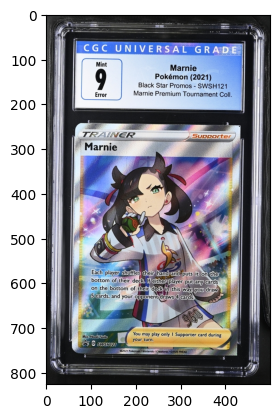

Based on what we predicted ::: 


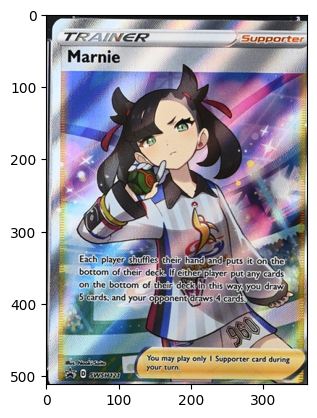

GROUND TRUTH ::: 


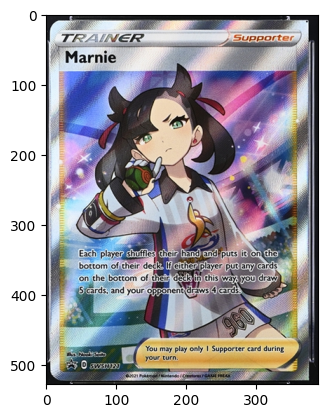

In [13]:
# inverse transform to get the original values

pokemon_number = 25
pokemon_selected = segmentation_df.iloc[pokemon_number]
image_p = pokemon_selected['image_path']
new_image = Image.open(image_p)
resized_image = new_image.resize((350, 220))

# normalize the pixel values
new_image_norm = np.asarray(resized_image) / 255.0
# make a prediction using the trained model
prediction = trained_model.predict(np.array([new_image_norm]))

# the output will be an array of 5 values for the x, y, height, width, and rotation values
print(prediction)

original_values = scaler.inverse_transform(prediction)

prediction = original_values[0]

print('Predicted Values :::', prediction)
print('Actual Values :::', pokemon_selected)

top = prediction[1] / 100
right = (100 - (prediction[0] + prediction[2])) / 100
bottom = (100 - (prediction[1] + prediction[3])) / 100
left = prediction[0] / 100
rotation = prediction[4] 

annotation_0 = image_p 
img = Image.open(annotation_0)

display_image(img)

cropped_img = crop_image(
    img,
    top,
    right,
    bottom,
    left,
    rotation,
)

print("Based on what we predicted ::: ")
display_image(cropped_img)



print("GROUND TRUTH ::: ")



annotation_0 = segmentation_df.iloc[pokemon_number]
img = Image.open(annotation_0["image_path"])

top = annotation_0["y"] / 100
right = (100 - (annotation_0["x"] + annotation_0["width"])) / 100
bottom = (100 - (annotation_0["y"] + annotation_0["height"])) / 100
left = annotation_0["x"] / 100
rotation = annotation_0["rotation"]

cropped_img = crop_image(
    img,
    top,
    right,
    bottom,
    left,
    rotation,
)
display_image(cropped_img)

In [ ]:
def input_image_get_cordinates(image_path, model):
    # inverse transform to get the original values

    image_p = pokemon_selected[image_path]
    new_image = Image.open(image_p)
    resized_image = new_image.resize((350, 220))

    # normalize the pixel values
    new_image_norm = np.asarray(resized_image) / 255.0
    # make a prediction using the trained model
    prediction = model.predict(np.array([new_image_norm]))

    # the output will be an array of 5 values for the x, y, height, width, and rotation values
    print(prediction)

    original_values = scaler.inverse_transform(prediction)

    prediction = original_values[0]

    print('Predicted Values :::', prediction)
    print('Actual Values :::', pokemon_selected)

    top = prediction[1] / 100
    right = (100 - (prediction[0] + prediction[2])) / 100
    bottom = (100 - (prediction[1] + prediction[3])) / 100
    left = prediction[0] / 100
    rotation = prediction[4] 

    annotation_0 = image_p 
    img = Image.open(annotation_0)

    display_image(img)

    cropped_img = crop_image(
        img,
        top,
        right,
        bottom,
        left,
        rotation,
    )

    print("Based on what we predicted ::: ")
    display_image(cropped_img)



    print("GROUND TRUTH ::: ")



    annotation_0 = segmentation_df.iloc[pokemon_number]
    img = Image.open(annotation_0["image_path"])

    top = annotation_0["y"] / 100
    right = (100 - (annotation_0["x"] + annotation_0["width"])) / 100
    bottom = (100 - (annotation_0["y"] + annotation_0["height"])) / 100
    left = annotation_0["x"] / 100
    rotation = annotation_0["rotation"]

    cropped_img = crop_image(
        img,
        top,
        right,
        bottom,
        left,
        rotation,
    )
    display_image(cropped_img)
    
    
    return prediction